<a href="https://colab.research.google.com/github/AlexandreCandidoXavier/BR-DWGD/blob/main/notebooks/exemplo2_google_earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados temporais de uma região (bacia)

Será mostrado como extrair dados de Tmax de uma bacia hidrográfica.

Informações sobre o asset BR-DWGD no GEE [aqui](https://code.earthengine.google.com/?asset=projects/ee-alexandrexavier/assets/BR-DWGD)

In [1]:
import ee
import geemap
import numpy as np
import datetime
import pandas as pd
import plotly.express as px

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project='ee-alexandrexavier') # our project in GEE

import geemap.colormaps as cm

In [4]:
# set function to get vizualization and parameters
# values 'vis_min' and 'vis_max' set to daily visialization
def parameters(var_name):
    if var_name == 'PR':
        var_set = {'offset': 225, 'scale': 0.00686666, 'var_name': 'PR', 'var_unit': 'mm', 'vis_min':0, 'vis_max':200}
    
    elif var_name == 'ET':
        var_set = {'offset': 0, 'scale': 0.05118110, 'var_name': 'ET', 'var_unit': 'mm', 'vis_min':0, 'vis_max':6}
    
    elif var_name == 'RH':
        var_set = {'offset': -0.393701, 'scale': 0.39370079, 'var_name': 'RH', 'var_unit': '%', 'vis_min':40, 'vis_max':100}
    
    elif var_name == 'U2':
        var_set = {'offset': -0.059055, 'scale': 0.05905512, 'var_name': 'U2', 'var_unit': 'm/s', 'vis_min':0, 'vis_max':4}
       
    elif var_name == 'RS':
        var_set = {'offset': -0.057087, 'scale': 0.15708661, 'var_name': 'RS', 'var_unit': 'MJ/m2', 'vis_min':5, 'vis_max':30}
    
    else: # TMAX or TMIN
        var_set = {'offset': 15, 'scale': 0.00106815, 'var_name': 'TMAX', 'var_unit': 'C', 'vis_min':10, 'vis_max':37}
  
  # set vizualization
    if var_set['var_name'] == 'PR':
        var_set['color_pal'] = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
    else:
        var_set['color_pal'] = ['040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6', '0602ff', '235cb1', '307ef3', '269db1', 
                                '30c8e2', '32d3ef','3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f','fff705', 'ffd611',
                                'ffb613', 'ff8b13', 'ff6e08', 'ff500d', 'ff0000', 'de0101', 'c21301', 'a71001', '911003']

    return var_set

Função para reescalonar

In [5]:
def scaleBand(image):
    scaledImage = image.multiply(var_set['scale']).add(var_set['offset'])
                           
    return scaledImage.copyProperties(image, image.propertyNames())

# Pegando a temperatura máxima e plotando

Será plotado o dado diário do primeiro dia da série que se definiu

In [6]:
#  Escolhendo a variável, podendo ser 'PR', 'ET, 'RH', 'U2', 'TMIN', 'RS' or 'TMAX'
var_name = 'Tmax'

# definindo período (tem limite para 5000 dias, 13,6 anos)
# o mapa de temperatura plotado será do dia 
start_date, end_date = '2009-01-01','2022-01-01' 

# pegando os parâmetros para reescalonamento e plotagem
var_set = parameters(var_name)

# pegando os dados e reecalonando
var = ee.ImageCollection('projects/ee-alexandrexavier/assets/BR-DWGD') \
                        .filterDate(start_date, end_date) \
                        .select(var_name) \
                        .map(scaleBand)

# pegando parametros para a vizualização 
vis = {'min':var_set['vis_min'], 
       'max': var_set['vis_max'], 
       'palette': var_set['color_pal']}

m = geemap.Map(center=[-15, -60], zoom=4)
m.addLayer(var.first(), vis, 'Tmax')
m

Map(center=[-15, -60], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

# Limites das bacias

Bacias do [Hydroatlas](https://www.hydrosheds.org/hydroatlas)

Outros níveis de escala [aqui](https://developers.google.com/earth-engine/datasets/tags/hydroatlas) 

In [7]:
bacias = ee.FeatureCollection('WWF/HydroATLAS/v1/Basins/level08')

In [8]:
# plotando todas as as bacias
m = geemap.Map(center=[-15, -60], zoom=4)
m.addLayer(bacias, {}, 'bacia')
m

Map(center=[-15, -60], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

### Selecionado uma feição (bacia) e calculando a área

Antes do rodar a célula abaixo, utilizando o mapa acima clique no icone "Draw a marker", e depois clique na bacia.

In [9]:
roi = bacias.filterBounds(ee.FeatureCollection(m.draw_features))
# simplificando
roi_simple = ee.FeatureCollection(roi.geometry().simplify(maxError=5000))

Calculando a área

In [10]:
# a unidade é de m2, transformamos para km2
area = roi_simple.geometry().area(1).divide(1e6).round()
print(area.getInfo(), 'km2')

1947 km2


### Plotando a Tmax somente para a bacia selecionada

Primeira data da coleção

In [ ]:
m = geemap.Map(center=[-15, -60], zoom=4)
m.addLayer(var.first().clip(roi_simple), vis, 'Tmax')
m.centerObject(roi_simple)
m

# Extraindo dados da bacia selecionada

Pegando a média dos valores diários na área selecionada

In [12]:
var_roi = var.toBands().reduceRegion(reducer=ee.Reducer.mean(),
                                        geometry=roi_simple,
                                        scale=11000).getInfo()

## Organizando os dados para dataframe

In [13]:
df = pd.DataFrame.from_dict(var_roi, orient='index', columns=[var_name])
df.index = pd.to_datetime(df.index.str.split('_').str[-2]).values
df.index.set_names('Data', inplace=True)
df

,Tmax
Data,
2009-01-01,32.440130
2009-01-02,31.888816
2009-01-03,31.471911
2009-01-04,32.290346
2009-01-05,25.361036
...,...
2021-12-27,30.763270
2021-12-28,29.633060
2021-12-29,30.089007


## Plotando os dados médios para a bacia selecionada

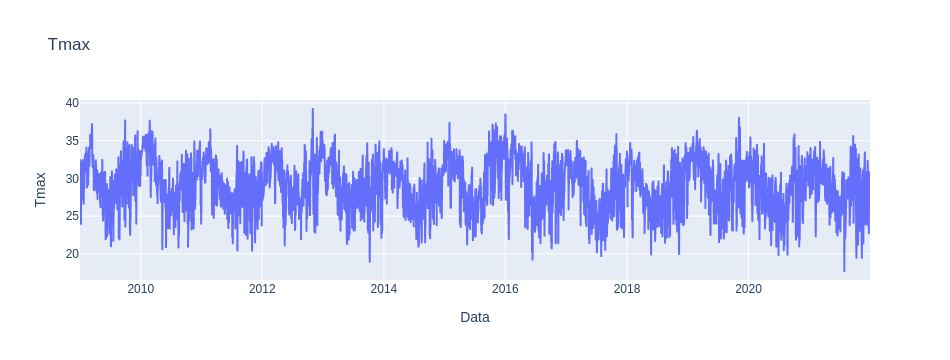

In [14]:
fig = px.line(df, x=df.index, 
              y=var_name,
              title=f"{var_name}")
fig.update_traces(hovertemplate="%{x}: %{y:.1f}°C")
fig.show()

In [20]:
# para salvar dados
df.to_csv('dados.csv')